# Raster-based market access

Following in the footsteps of the Malaria Atlas Project's <a href="https://developers.google.com/earth-engine/datasets/catalog/Oxford_MAP_friction_surface_2015_v1_0">Global Friction Surface</a>, this notebook explores a set of tools for calculating:

1. Travel time rasters
2. Drive-time polygons
3. Marketsheds


In [ ]:
import sys, os, importlib
import rasterio

import pandas as pd
import geopandas as gpd
import skimage.graph as graph

import GOSTrocks.rasterMisc as rMisc
import GOSTrocks.mapMisc as mapMisc

sys.path.append("../../src")

import GOSTnetsraster.market_access as ma

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
iso3 = 'SEN'

local_folder = f"C:/WBG/Work/Projects/HealthAccess/Tutorials/GNR/{iso3}"
results_folder = os.path.join(local_folder,"results") #os.path.join(base_folder, iso3)
least_cost_tt_file = os.path.join(results_folder, "least_cost_travel_time.tif")

if not os.path.exists(results_folder):
    os.makedirs(results_folder)
tutorial_folder = "tutorial_data"
    
dests = os.path.join(tutorial_folder, f"{iso3}_cities.geojson")
friction_surface = os.path.join(tutorial_folder, f"{iso3}_friction_surface.tif")
# if you completed the friction surface generation step, you can also use:
friction_surface = os.path.join(local_folder, f"friction_surface.tif")

inD = gpd.read_file(dests)
inR = rasterio.open(friction_surface)
inD = inD.to_crs(inR.crs) # destinations and raster need to be in the same CRS


In [3]:
frictionD = inR.read()[0,:,:]
# convert friction surface to traversal time (lazily). Original data are
#    the original data are minutes to travel 1 m, so we will convert to 
#    minutes to cross the cell
frictionD = frictionD * inR.res[0]  # cell size in meters
mcp = graph.MCP_Geometric(frictionD)

In [4]:
ma.calculate_travel_time?

Signature: ma.calculate_travel_time(inH, mcp, destinations, out_raster='')
Docstring:
Calculate travel time raster

INPUTS
    inH [rasterio object] - template raster used to identify locations of destinations
    mcp [skimage.graph.MCP_Geometric] - input graph
    destinations [geopandas df] - destinations for nearest calculations
    
LINKS
    https://scikit-image.org/docs/0.7.0/api/skimage.graph.mcp.html#skimage.graph.mcp.MCP.find_costs
File:      c:\wbg\work\code\gostnetsraster\src\gostnetsraster\market_access.py
Type:      function

In [ ]:
travel_costs, traceback = ma.calculate_travel_time(inR, mcp, inD)
travel_costs = travel_costs.astype(inR.meta['dtype'])
with rasterio.open(least_cost_tt_file, 'w', **inR.meta) as out_file:
    out_file.write_band(1, travel_costs)

<module 'matplotlib.pyplot' from 'c:\\WBG\\Anaconda3\\envs\\s2s_ingest\\lib\\site-packages\\matplotlib\\pyplot.py'>

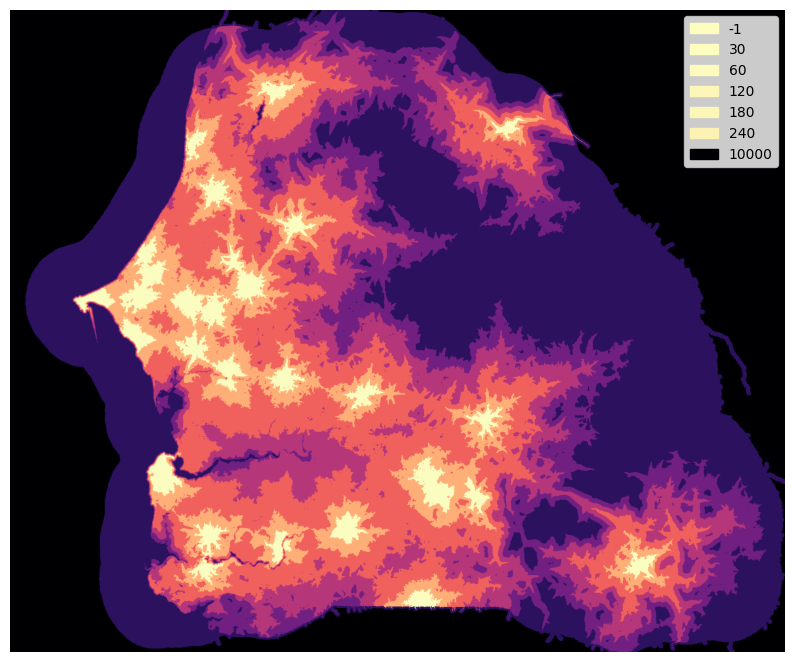

In [12]:
mapMisc.static_map_raster(rasterio.open(least_cost_tt_file), thresh=[-1,30,60,120,180,240,10000], reverse_colormap=True)

In [13]:
ma.generate_feature_vectors?

Signature:
ma.generate_feature_vectors(
    network_r,
    mcp,
    inH,
    threshold,
    featIdx='tempID',
    verbose=True,
)
Docstring:
Generate individual market sheds for each feature in the input dataset

INPUTS
    network_r [rasterio] - raster from which to grab index for calculations in MCP
    mcp [skimage.graph.MCP_Geometric] - input graph
    inH [geopandas data frame] - geopandas data frame from which to calculate features
    threshold [list of int] - travel treshold from which to calculate vectors in units of graph
    featIdx [string] - column name in inH to append to output marketshed dataset. 'tempID' for default.
    
RETURNS
    [geopandas dataframe]
File:      c:\wbg\work\code\gostnetsraster\src\gostnetsraster\market_access.py
Type:      function

In [14]:
drive_time_thresholds = [60, 120, 180, 240] # minutes
drive_vectors = ma.generate_feature_vectors(inR, mcp, inD, drive_time_thresholds)
drive_vectors.to_file(os.path.join(results_folder, "drive_vectors.shp"))

20:42:09	1 of 30: 0
20:42:09	2 of 30: 1
20:42:10	3 of 30: 2
20:42:11	4 of 30: 3
20:42:11	5 of 30: 4
20:42:12	6 of 30: 5
20:42:13	7 of 30: 6
20:42:14	8 of 30: 7
20:42:14	9 of 30: 8
20:42:15	10 of 30: 9
20:42:16	11 of 30: 10
20:42:17	12 of 30: 11
20:42:17	13 of 30: 12
20:42:18	14 of 30: 13
20:42:19	15 of 30: 14
20:42:20	16 of 30: 15
20:42:20	17 of 30: 16
20:42:21	18 of 30: 17
20:42:22	19 of 30: 18
20:42:23	20 of 30: 19
20:42:23	21 of 30: 20
20:42:24	22 of 30: 21
20:42:25	23 of 30: 22
20:42:26	24 of 30: 23
20:42:26	25 of 30: 24
20:42:27	26 of 30: 25
20:42:28	27 of 30: 26
20:42:29	28 of 30: 27
20:42:29	29 of 30: 28
20:42:30	30 of 30: 29


In [15]:
drive_vectors.head()

,geometry,threshold,IDX
0,"MULTIPOLYGON (((-1595764.876 1559707.728, -159...",60,0
1,"MULTIPOLYGON (((-1561945.184 1544724.32, -1561...",120,0
2,"MULTIPOLYGON (((-1538399.83 1522035.16, -15383...",180,0
3,"MULTIPOLYGON (((-1569222.84 1489071.664, -1569...",240,0
4,"MULTIPOLYGON (((-1555523.724 1404736.484, -155...",60,1


c:\WBG\Anaconda3\envs\s2s_ingest\lib\site-packages\GOSTrocks\mapMisc.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, mdata in v_data.groupby("tomap"):


Error adding basemap


<module 'matplotlib.pyplot' from 'c:\\WBG\\Anaconda3\\envs\\s2s_ingest\\lib\\site-packages\\matplotlib\\pyplot.py'>

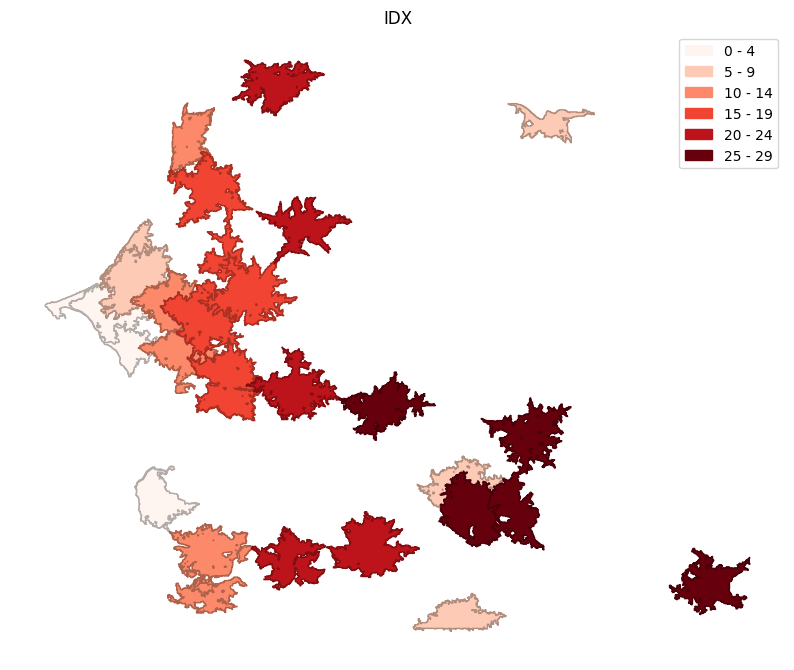

In [20]:
mapMisc.static_map_vector(drive_vectors.loc[drive_vectors['threshold'] == 60], map_column='IDX')

In [21]:
ma.calculate_gravity?

Signature:
ma.calculate_gravity(
    inH,
    mcp,
    dests,
    gravity_col,
    outfile='',
    decayVals=[0.01, 0.005, 0.001, 0.0007701635, 0.0003850818, 0.0001925409, 9.62704e-05, 3.85082e-05, 1e-05],
)
Docstring:
Using a friction surface, run a gravity model to evaluate access to all cities

Parameters
----------
inH : rasterio object
    rasterio object of friction surface
mcp : skimage.graph.MCP_Geometric
    graph used to calculate travel times; must match shape of inH
dests : geopandas dataframe
    Destination coordinates for gravity model, must be in same CRS as inH
gravity_col : string
    column in dests that describes the attractiveness of the destination
outfile : string, optional
    Path to save the gravity model output. Defaults to '' which writes nothing
decayVals : list, optional
    List of decay values for market access. Defaults to a predefined list.

Returns
-------
final_gravity : numpy array
    3D array of gravity model results, with the third dimension corr

In [22]:
# calculate gravity to nearest cities, using the population column GC_POP_TOT_2025
gravity_col = "GC_POP_TOT_2025"
gravity_file = os.path.join(results_folder, f"gravity_cities_{gravity_col}.tif")
gravity = ma.calculate_gravity(inR, mcp, inD, gravity_col, outfile = gravity_file)

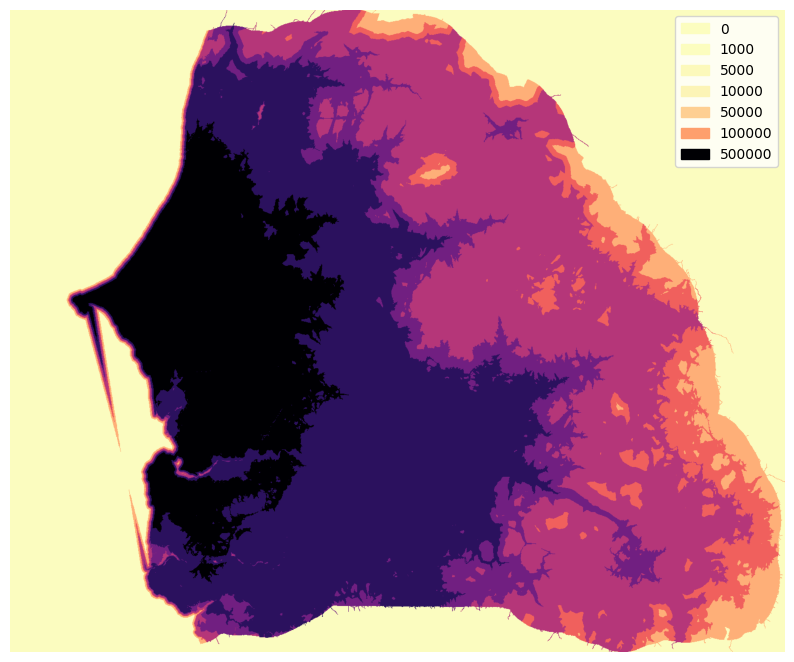

In [30]:
with rMisc.create_rasterio_inmemory(inR.meta, gravity['gravity'][:,:,0]) as gravity_raster:
    mapMisc.static_map_raster(gravity_raster, thresh=[0,1000,5000,10000,50000,100000,500000], reverse_colormap=True)